In [88]:
using SparseArrays, LinearAlgebra, Plots, LaTeXStrings

In [2]:
pyplot()

Plots.PyPlotBackend()

In [95]:
# parameter values
sigma  = 1.5;                    # risk aversion              
beta   = 0.99322;                # discount factor 
prob   = [0.925 0.075; .5 .5];   # prob(i,j) = probability (s(t+1)=sj | s(t) = si)
theta  = 0.1;                    # non-interest income if unemployed
wage   = 1.00;                   # non-interest income if employed
Rstart = 1;                      # initial gross interest rate
F      = -2.0;                   # borrowing constraint parameter 

# initialization
A      = 1.0;
Aold   = 1.0;
Anew   = 1.0;
meanA  = 1.0;

# asset grid
maxast = 4;                      # maximum value of asset grid   
minast = F;                      # minimum value of asset grid
incast = 0.01;                   # size of asset grid increments
nasset = trunc(Int,((maxast-minast)/incast+1)); # number of grid points
assetp = 1.0;

# global variables
decis   = zeros(nasset,2);
tdecis  = zeros(nasset,2);
lambda  = zeros(nasset,2);
probk_copy  = zeros(nasset,1);


In [96]:
liter   = 1;
maxiter = 1000;
toler   = 0.00000000001;
step    = 0.05;
R = Rstart;
Q = Qstart;
flag = 1;

println("Iterating On r");
println("");
println("Iter       r                              A                              newstep");
while  (flag != 0) && (liter <= maxiter);
    
    util1=-10000*ones(nasset,nasset);     # utility when employed     
    util2=-10000*ones(nasset,nasset);     # utility when unemployed   
    
    for i=1:nasset
        asset=(i-1)*incast + minast;
        for j=1:nasset
            assetp = (j-1)*incast + minast;
            cons = wage + R*asset - assetp;
            if assetp >= F && cons > 0;
                util1[j,i]=(cons)^(1-sigma)/(1-sigma);
            end;
        end
        for j=1:nasset
            assetp = (j-1)*incast + minast;
            cons = theta*wage + R*asset - assetp;
            if assetp>= F && cons > 0;
                util2[j,i]=(cons)^(1-sigma)/(1-sigma);
            end;
        end;
    end;

#  initialize some variables
    v       = zeros(nasset,2);
    tdecis1 = zeros(nasset,2);
    tdecis2 = zeros(nasset,2);    

    test1   = 10;
    test2   = 10;
    rs,cs   = size(util1);
    r1      = zeros(nasset,nasset);
    r2      = zeros(nasset,nasset);

    while (test2 > 1e-3);
        for i=1:cs;
            r1[:,i]=util1[:,i]+beta*(prob[1,1]*v[:,1]+ prob[1,2]*v[:,2]);
            r2[:,i]=util2[:,i]+beta*(prob[2,1]*v[:,1]+ prob[2,2]*v[:,2]);
        end;
        
        (tv1,inds1)= findmax(r1,dims=1);
        tdecis1    = map(x->Base._ind2sub(r1, x)[1], inds1) 
        (tv2,inds2)= findmax(r2,dims=1);
        tdecis2    = map(x->Base._ind2sub(r2, x)[1], inds2) 
        
        tdecis=[tdecis1' tdecis2'];
        tv=[tv1' tv2'];

        test1=maximum((tdecis.-decis));
        test2 = norm(tv.-v);
        #test2 = maximum(abs.(tv.-v));
        
        copy!(v, tv);
        copy!(decis, tdecis); 
    end;
    decis=(decis.-1)*incast .+ minast;

    g2=spzeros(cs,cs);
    g1=spzeros(cs,cs);
    for i=1:cs
        g1[i,tdecis1[i]]=1;
        g2[i,tdecis2[i]]=1;
    end
    trans=[ prob[1,1]*g1 prob[1,2]*g1; prob[2,1]*g2 prob[2,2]*g2];
    trans=trans';
    probst = (1/(2*nasset))*ones(2*nasset,1);
    test = 1;
    while test > 10.0^(-8);
        probst1 = trans*probst;
        test = maximum(abs.(probst1-probst));
        copy!(probst, probst1);
    end; 

    aa=vec(decis);
    meanA=(probst'*aa)[1];
   
    lambda=reshape(probst, cs,2)


    lambda=reshape(probst, cs,2)
    probk=sum(lambda',dims=1);            # stationary distribution of capital - sum by each column
    probk=probk'
    probk_copy = probk

    
    if liter == 1;
        A=copy(meanA);; 
        if meanA > 0.0;
            step=copy(-step);
        end;
    end;

    Aold = copy(A);
    Anew = copy(meanA);

    if sign(Aold) != sign(Anew)
        step = copy(-.5*step);
    end;
    println(liter,"       ",R^6-1,"                             ",meanA,"                        ",step);
    
    R=copy(R+step);
    if abs.(Anew) < 0.0025
        flag = 0;
    end;
    
    A=copy(Anew);
    liter = liter+1;

end;

Iterating On r

Iter       r                              A                              newstep
1       0                             1.4248177627045235                        -0.05
2       -0.2649081093750002                             -1.100088465803383                        0.025
3       -0.14093169897460944                             -0.5254131982821371                        0.025
4       0.0                             1.4248177627045235                        -0.0125
5       -0.07269494811630228                             0.03480101481107727                        -0.0125
6       -0.1409316989746089                             -0.5254131982821371                        0.00625
7       -0.10735655835574831                             -0.2873594040309214                        0.00625
8       -0.07269494811630228                             0.03480101481107727                        -0.003125
9       -0.0901632960740244                             -0.13948291660551           

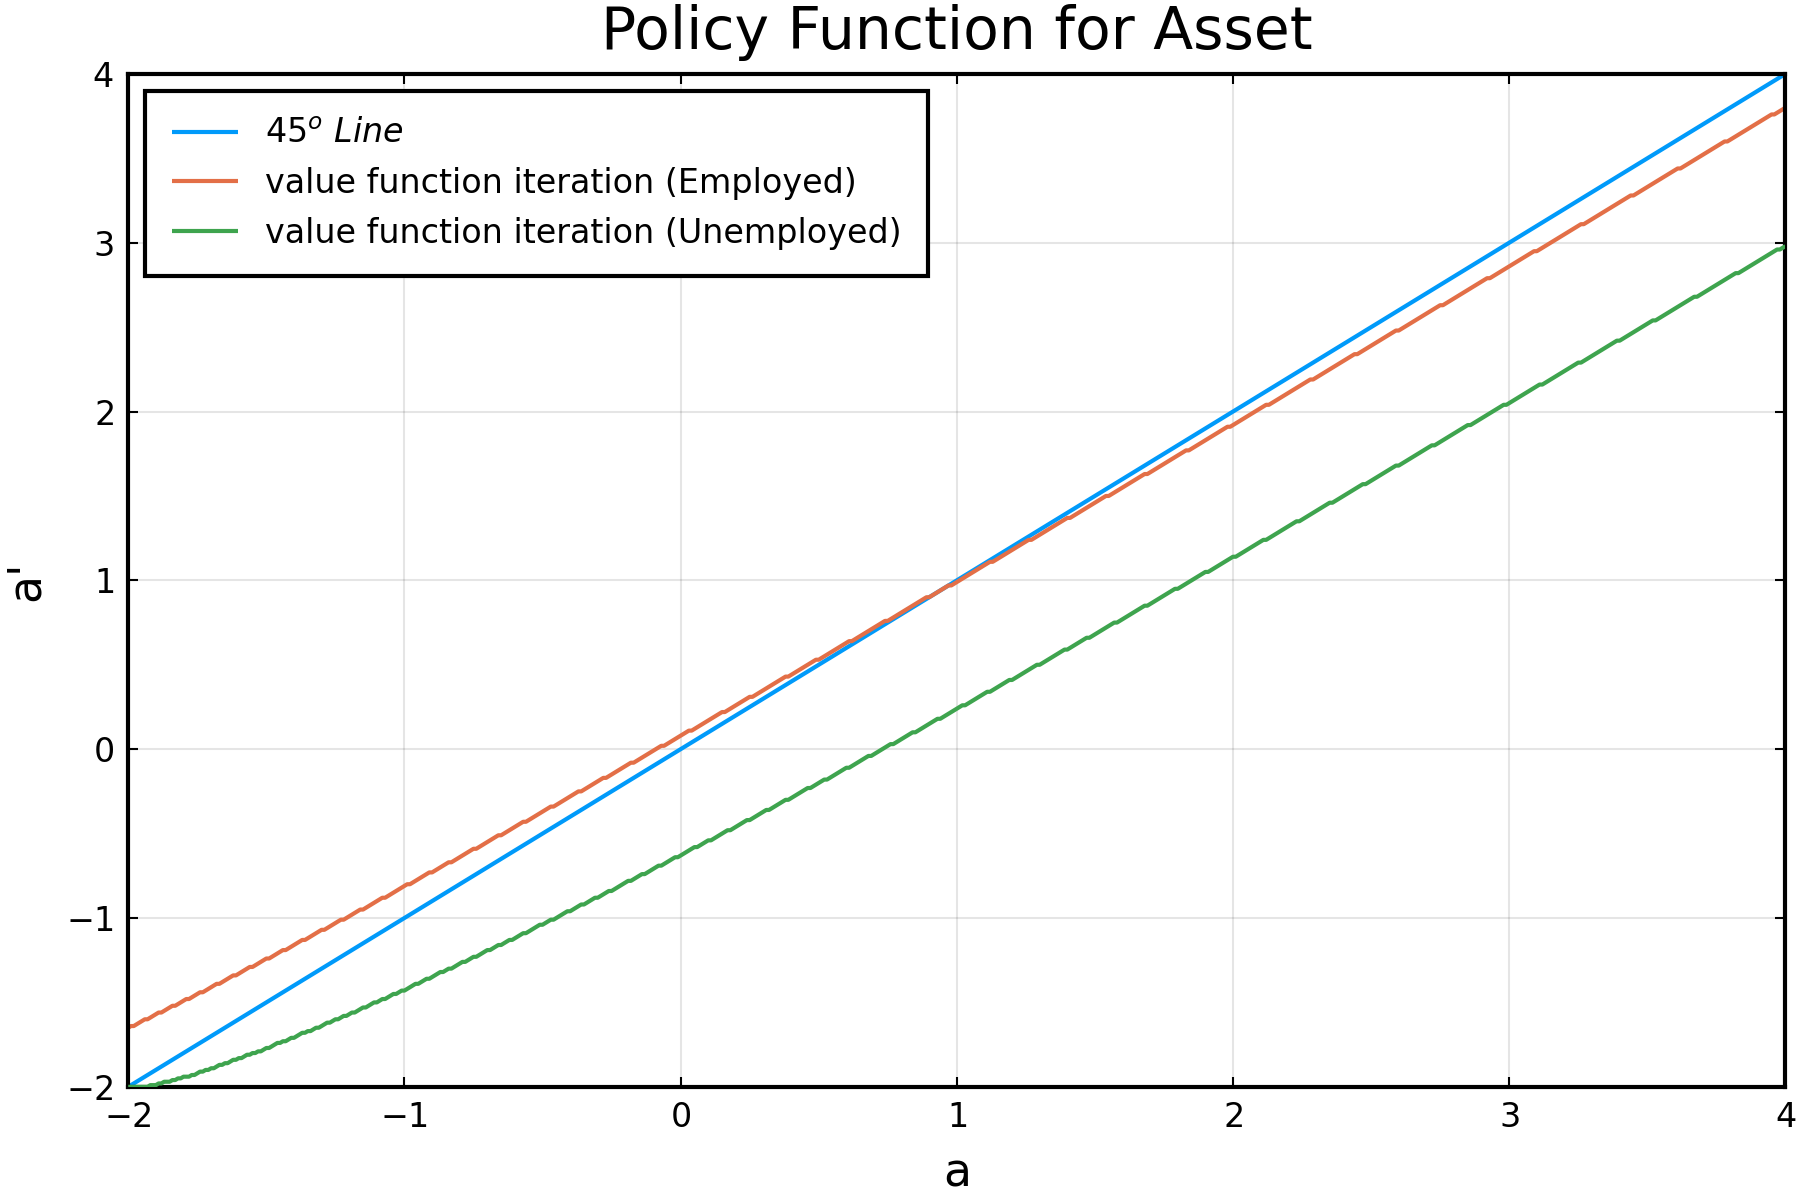

In [101]:
grid = collect(minast:incast:maxast);  

plot(grid, grid, xlabel = "a", ylabel = "a'", title = "Policy Function for Asset (Credit)", label = L"45^o~Line", framestyle = :box)
plot!(grid, grid[tdecis[:,1]], label = "value function iteration (Employed)", xlabel = "a", ylabel = "a'", title = "Policy Function for Asset", framestyle = :box,legend=:topleft)
p1 = plot!(grid, grid[tdecis[:,2]], label = "value function iteration (Unemployed)", xlabel = "a", ylabel = "a'", title = "Policy Function for Asset", framestyle = :box,legend=:topleft)
plot(p1, layout = 1, dpi=300)
xlims!((-2,4))
ylims!((-2,4))

#savefig("main.png")

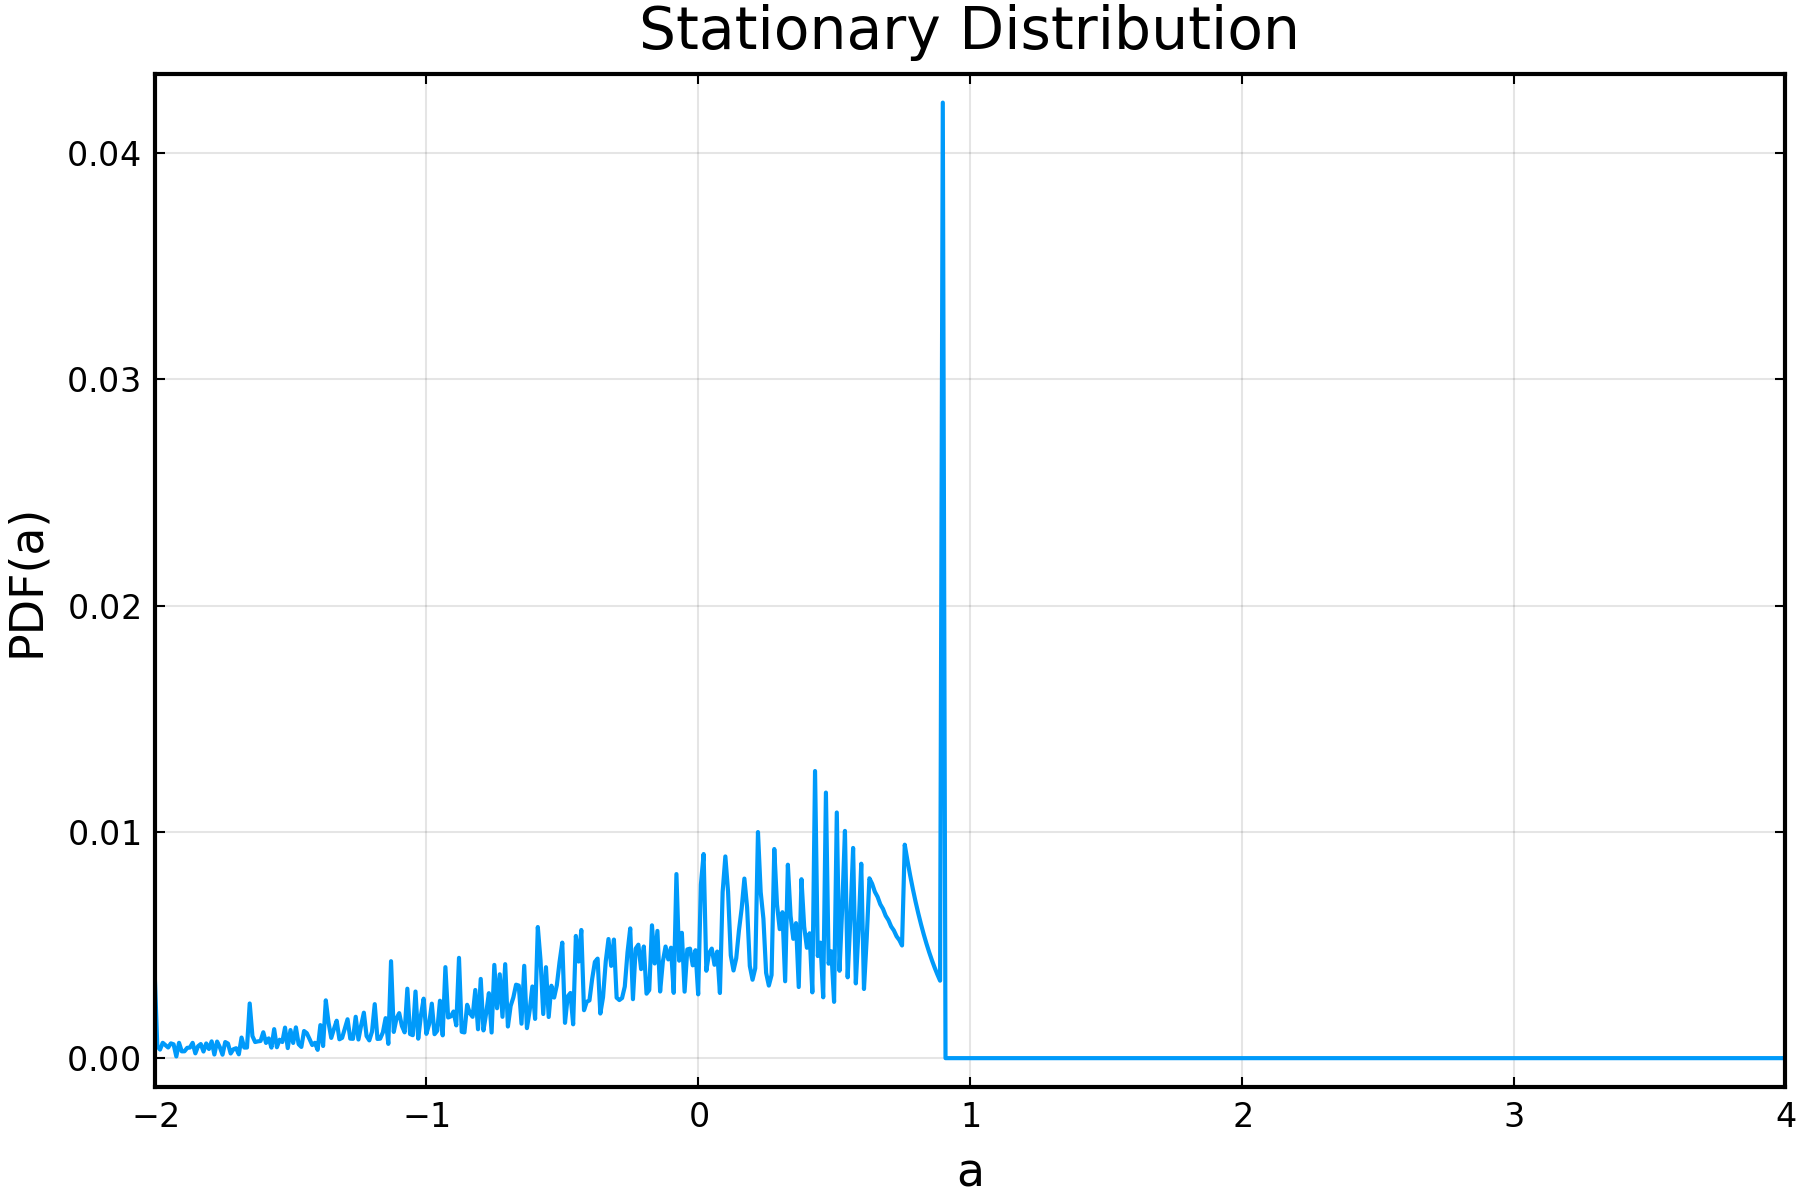

In [102]:
p1 = plot(grid, probk_copy, xlabel = "a", ylabel = "PDF(a)", title = "Stationary Distribution", legend = false, framestyle = :box)
plot(p1, layout = 1, dpi=300)
#vline!([-2,1], linestyles=:dash)
xlims!((-2,4))
#savefig("3_6.png")